## WEATHER DATASET PREPROCESSING AND FEATURE ENGINEERING 🚀.

These will be the basic outline of steps that we'll be following in order clean and pre-process our data set:
1. Missing Values Treatment.
2. Outlier Treatment.
3. Redundant Columns Removal / Checking Co-relation.
4. Data Encoding or Data Split
5. Data Scaling (Normalization or Standardization)

In [2]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
import category_encoders as ce
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier, BaggingClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
import pandas as pd
import tensorflow as tf
import warnings
warnings.simplefilter('ignore')
sns.set_theme(style="dark")

#### STEP 1: Missing Values Treatment

In [3]:
def check_null_values(df):
    for column in df.columns.to_list():
        count = 0
        for isNullValue in df[column].isna().tolist():
            if isNullValue:
                count += 1
        if (count > 0):
            print(f'There are {count} null values in column {column}')

In [4]:
df = pd.read_csv('../../data/weather.csv')
check_null_values(df)

There are 517 null values in column Precip Type


Hence dropping all those 517 rows which has null values in their **Precip Type** column

In [5]:
df_cleaned = df.dropna(subset=['Precip Type'])
check_null_values(df_cleaned)

In [6]:
def plot_blox_plot(df_cleaned):
    numerical_columns = df_cleaned.select_dtypes(include=np.number).columns.to_list()
    # Set up the grid for the subplots
    fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(15, 15))

    # Iterate over the columns and plot box plots
    for i, column in enumerate(numerical_columns):
        row = i // 2
        col = i % 2
        sns.boxplot(x=df_cleaned[column], ax=axes[row, col])
        axes[row, col].set_xlabel(column)

    # Adjust the spacing between subplots
    plt.tight_layout()

    # Show the plot
    plt.show()


def plot_column_box_plot(column):
    sns.boxplot(x=df_cleaned[column])

#### STEP 2: Outlier Treatment

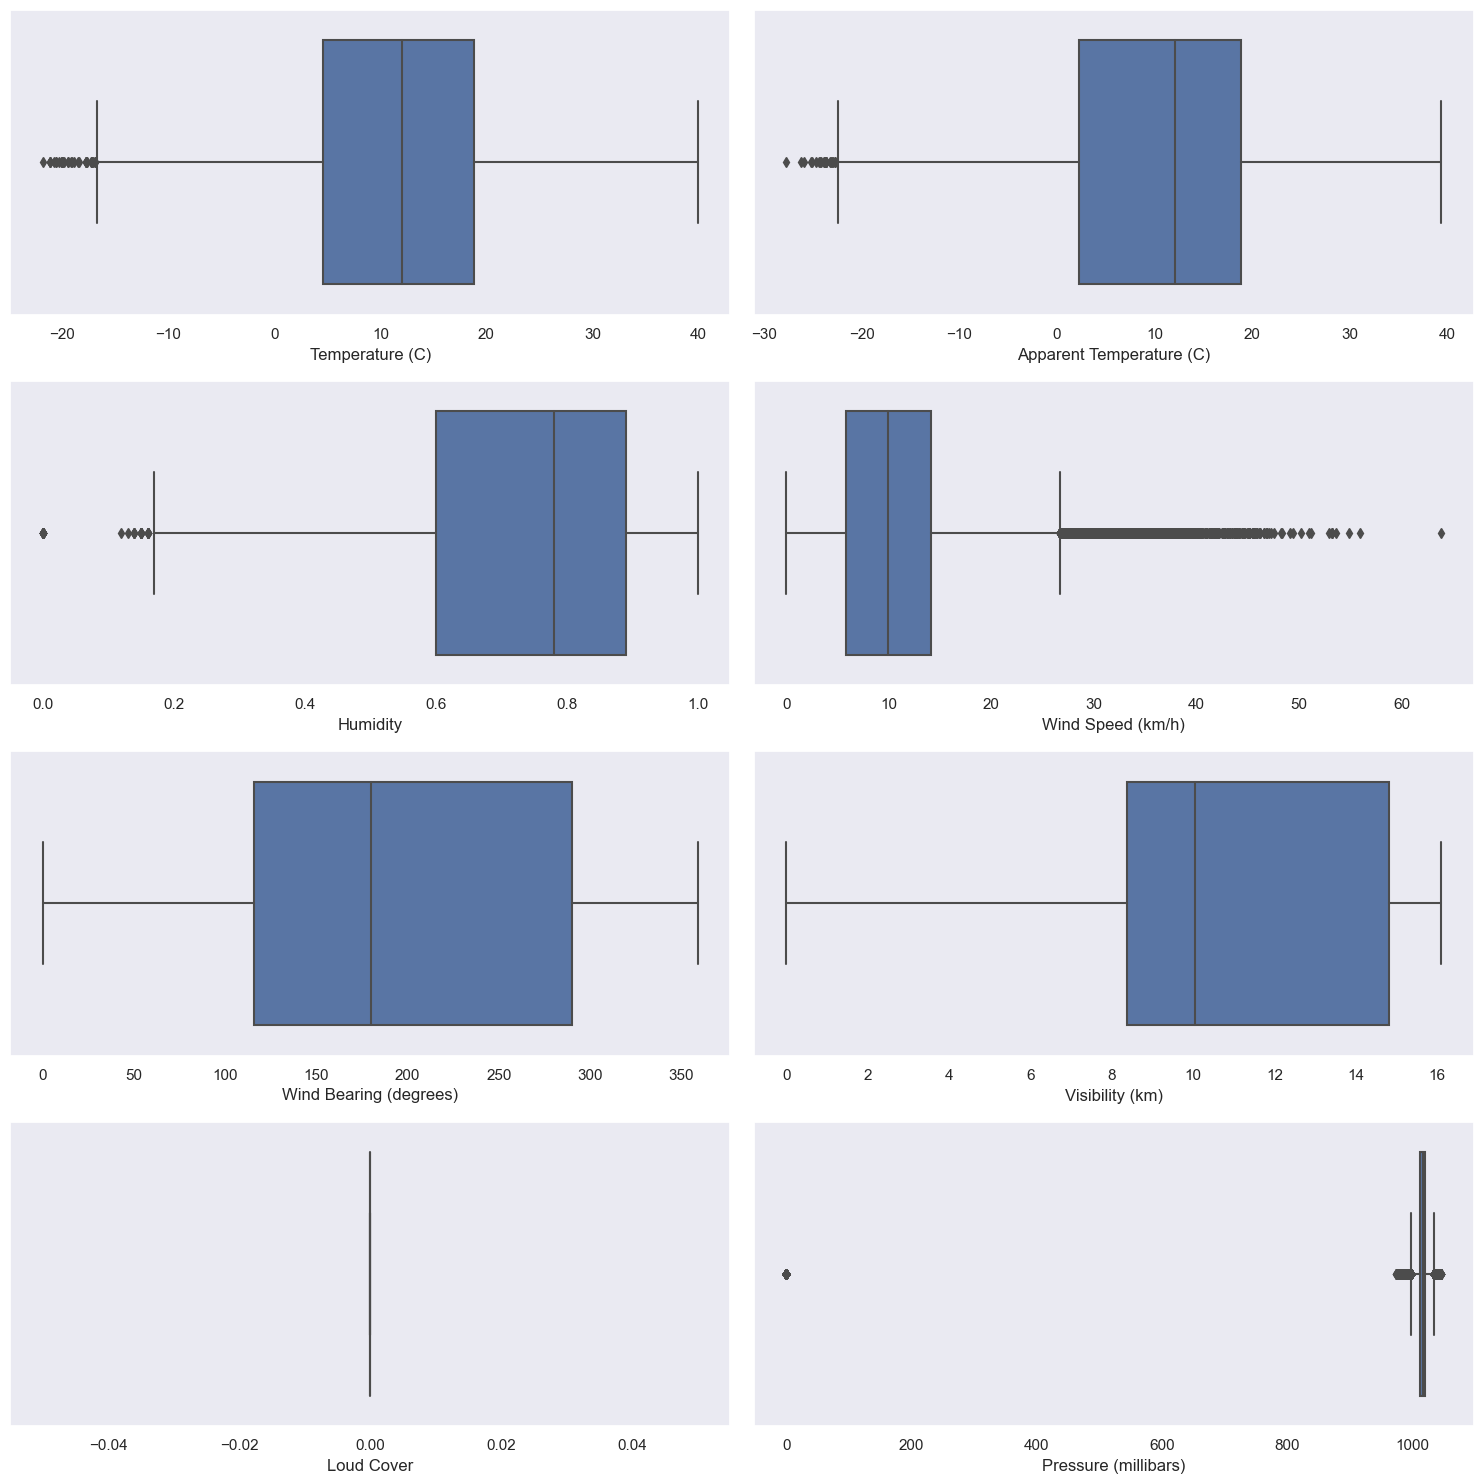

In [7]:
plot_blox_plot(df_cleaned)

In [8]:
numerical_columns = df_cleaned.select_dtypes(include=np.number).columns.drop('Summary', errors='ignore').to_list()
numerical_columns

['Temperature (C)',
 'Apparent Temperature (C)',
 'Humidity',
 'Wind Speed (km/h)',
 'Wind Bearing (degrees)',
 'Visibility (km)',
 'Loud Cover',
 'Pressure (millibars)']

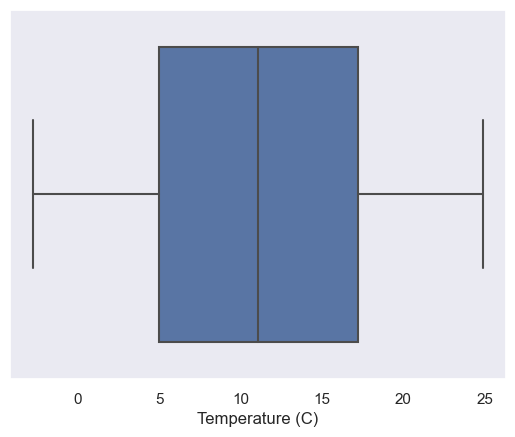

In [9]:
min_threshold, max_threshold = df_cleaned['Temperature (C)'].quantile([0.0500, 0.900])
df_cleaned = df_cleaned[(df_cleaned['Temperature (C)'] < max_threshold) & (df_cleaned['Temperature (C)'] > min_threshold)]
plot_column_box_plot('Temperature (C)')

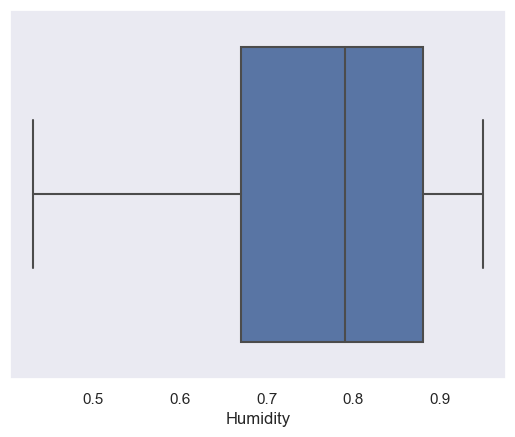

In [10]:
min_threshold, max_threshold = df_cleaned['Humidity'].quantile([0.0500, 0.900])
df_cleaned = df_cleaned[(df_cleaned['Humidity'] < max_threshold) & (df_cleaned['Humidity'] > min_threshold)]
plot_column_box_plot('Humidity')

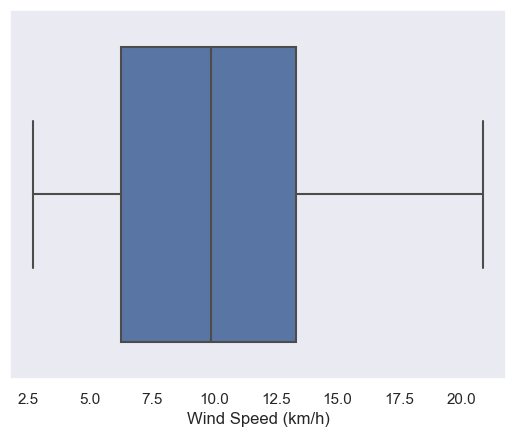

In [11]:
min_threshold, max_threshold = df_cleaned['Wind Speed (km/h)'].quantile([0.0500, 0.900])
df_cleaned = df_cleaned[(df_cleaned['Wind Speed (km/h)'] < max_threshold) & (df_cleaned['Wind Speed (km/h)'] > min_threshold)]
plot_column_box_plot('Wind Speed (km/h)')

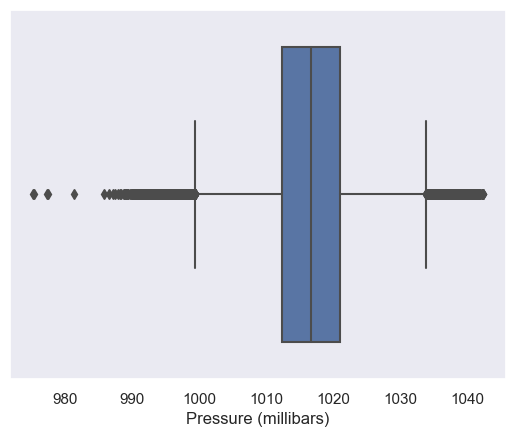

In [12]:
df_cleaned = df_cleaned[(df_cleaned['Pressure (millibars)'] != 0)]
plot_column_box_plot('Pressure (millibars)')

In [13]:
df_cleaned.shape

(57806, 12)

#### STEP 3: Redundant Columns Removal / Checking Co-Relation

In [14]:
# Finding the Co-relation matrix of the dataset so far.
non_numeric_columns = df_cleaned.select_dtypes(exclude=np.number).columns
df_numeric = df_cleaned.drop(non_numeric_columns, axis=1)
correlation_matrix = df_numeric.corr()
correlation_matrix

,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars)
Temperature (C),1.000000,0.993356,-0.436118,-0.067092,0.010862,0.339184,NaN,-0.287559
Apparent Temperature (C),0.993356,1.000000,-0.419398,-0.130626,0.013867,0.333928,NaN,-0.268710
Humidity,-0.436118,-0.419398,1.000000,-0.170628,0.053025,-0.296848,NaN,-0.042816
Wind Speed (km/h),-0.067092,-0.130626,-0.170628,1.000000,0.018529,0.003875,NaN,-0.177986
Wind Bearing (degrees),0.010862,0.013867,0.053025,0.018529,1.000000,0.045711,NaN,-0.051539
Visibility (km),0.339184,0.333928,-0.296848,0.003875,0.045711,1.000000,NaN,-0.110652
Loud Cover,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Pressure (millibars),-0.287559,-0.268710,-0.042816,-0.177986,-0.051539,-0.110652,NaN,1.000000


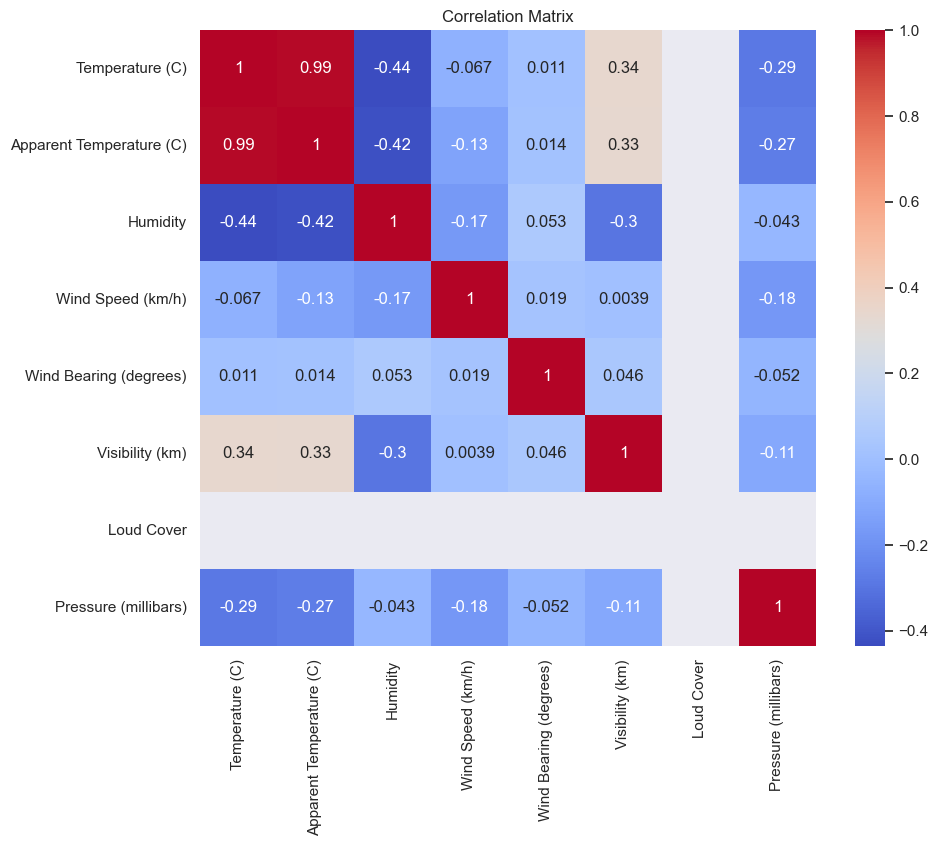

In [15]:
# Now Visualizing the Co-relation matrix as a heat map
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', square=True)
plt.title('Correlation Matrix')
plt.show()

In [16]:
# Finding the co-related columns by comparing them with a fixed threshold
threshold = 0.7
correlated_columns = set()

for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > threshold:
            colname = correlation_matrix.columns[i]
            correlated_columns.add(colname)

correlated_columns

{'Apparent Temperature (C)'}

In [17]:
# Removing the Co-related column 'Apparent Temperature (C)' from the cleaned dataset so far.
df_cleaned = df_cleaned.drop(correlated_columns, axis=1)
df_cleaned.shape

(57806, 11)

In [18]:
# Removing the "Daily Summary" and the "Loud Cover" Column as it has no such relevance. 
df_cleaned = df_cleaned.drop("Daily Summary", axis=1)
df_cleaned = df_cleaned.drop("Loud Cover", axis=1)
df_cleaned.shape

(57806, 9)

In [19]:
# Checking if there are any duplicate rows in the dataset, if yes then removing them up.
duplicate_rows = df_cleaned.duplicated()
df_cleaned = df_cleaned.drop_duplicates()
df_cleaned.shape

(57804, 9)

#### STEP 4: Data Encoding or Data Split

In [20]:
# Selecting Only Three Classes and Removing the Rest of them.
df_cleaned['Summary'].value_counts()

Summary
Mostly Cloudy              19576
Partly Cloudy              18692
Overcast                   10965
Clear                       6605
Foggy                       1822
Light Rain                    53
Drizzle                       34
Humid and Mostly Cloudy       28
Humid and Partly Cloudy       16
Rain                           7
Humid and Overcast             6
Name: count, dtype: int64

In [21]:
# Taking the top three most occurred classes i.e ('Mostly Cloudy', 'Partly Cloudy', and 'Overcast').
top_classes = ['Overcast', 'Clear', 'Foggy']
df_cleaned = df_cleaned[df_cleaned['Summary'].isin(top_classes)]
# df_cleaned["Summary"].replace(
#     ["Mostly Cloudy", "Partly Cloudy"], "Cloudy", inplace=True
# )
# df_cleaned["Summary"].replace(
#     [
#         "Clear",
#         "Foggy",
#         "Breezy and Overcast",
#         "Breezy and Mostly Cloudy",
#         "Breezy and Partly Cloudy",
#         "Dry and Partly Cloudy",
#         "Windy and Partly Cloudy",
#         "Light Rain",
#         "Breezy",
#         "Windy and Overcast",
#         "Humid and Mostly Cloudy",
#         "Drizzle",
#         "Breezy and Foggy",
#         "Windy and Mostly Cloudy",
#         "Dry",
#         "Humid and Partly Cloudy",
#         "Dry and Mostly Cloudy",
#         "Rain",
#         "Windy",
#         "Humid and Overcast",
#         "Windy and Foggy",
#         "Windy and Dry",
#         "Dangerously Windy and Partly Cloudy",
#         "Breezy and Dry",
#     ],
#     "others",
#     inplace=True,
# )
df_cleaned["Summary"].value_counts()

Summary
Overcast    10965
Clear        6605
Foggy        1822
Name: count, dtype: int64

In [22]:
# Seeing how many textual are there which need to be encoded
df_cleaned.select_dtypes(exclude=np.number).columns.to_list()

['Formatted Date', 'Summary', 'Precip Type']

In [23]:
df_cleaned['Summary'].unique()

array(['Overcast', 'Foggy', 'Clear'], dtype=object)

In [24]:
# First encoding the Target Attribute by Label Encoding Scheme.
label_encoder = LabelEncoder()
encoded_column = label_encoder.fit_transform(df_cleaned['Summary'])
df_cleaned['Summary'] = encoded_column

# Get the mapping between numeric and textual values
mapping = dict(zip(range(len(label_encoder.classes_)), label_encoder.classes_))

# Print the mapping
for code, text in mapping.items():
    print(f"{text} --> {code}")

# df_cleaned.head()

Clear --> 0
Foggy --> 1
Overcast --> 2


In [25]:
df_cleaned['Summary'].unique()

array([2, 1, 0])

In [26]:
df_cleaned.select_dtypes(exclude=np.number).columns.to_list()

['Formatted Date', 'Precip Type']

In [27]:
# Checking the 'Precip Type' column to see which encoding technique to apply.
df_cleaned['Precip Type'].unique()

array(['rain', 'snow'], dtype=object)

In [28]:
# Encoding the "Precip Type" column using the Lable Encoder Technique as it has only two unique values.
label_encoder = LabelEncoder()
encoded_column = label_encoder.fit_transform(df_cleaned['Precip Type'])
df_cleaned['Precip Type'] = encoded_column
# df_cleaned.head()

# Get the mapping between numeric and textual values
mapping = dict(zip(range(len(label_encoder.classes_)), label_encoder.classes_))

# Print the mapping
for code, text in mapping.items():
    print(f"{text} --> {code}")


rain --> 0
snow --> 1


In [29]:
# Checking the 'Formatted Date' column to see which encoding technique to apply.
df_cleaned['Formatted Date']

46       2006-04-10 22:00:00.000 +0200
47       2006-04-10 23:00:00.000 +0200
48       2006-04-11 00:00:00.000 +0200
49       2006-04-11 01:00:00.000 +0200
51       2006-04-11 03:00:00.000 +0200
                     ...              
96432    2016-09-09 03:00:00.000 +0200
96433    2016-09-09 04:00:00.000 +0200
96434    2016-09-09 05:00:00.000 +0200
96435    2016-09-09 06:00:00.000 +0200
96436    2016-09-09 07:00:00.000 +0200
Name: Formatted Date, Length: 19392, dtype: object

In [30]:
# Extracting useful pieces of information such as "Year", "Month", "Day" and "Hour" as separate columns from a single "Formatted Date" column and then encoding those four columns by Label Encoding.

# Instantiating the LabelEncoder Object.
label_encoder = LabelEncoder()

# Convert the "Formatted Date" column to datetime format
date_col = pd.to_datetime(df_cleaned['Formatted Date'], utc=True)

# Verify the data type of 'Formatted Date'
# print(df_cleaned['Formatted Date'].dtype)

# Extract datetime features
df_cleaned['Year'] = date_col.dt.year
df_cleaned['Month'] = date_col.dt.month
df_cleaned['Day'] = date_col.dt.day
df_cleaned['Hour'] = date_col.dt.hour

# Encode the extracted features using LabelEncoder
df_cleaned['Year'] = label_encoder.fit_transform(df_cleaned['Year'])
df_cleaned['Month'] = label_encoder.fit_transform(df_cleaned['Month'])
df_cleaned['Day'] = label_encoder.fit_transform(df_cleaned['Day'])
df_cleaned['Hour'] = label_encoder.fit_transform(df_cleaned['Hour'])

# Drop the original "Formatted Date" column
df_cleaned.drop('Formatted Date', axis=1, inplace=True)
# df_cleaned.head()

# Get the mapping between numeric and textual values
mapping = dict(zip(range(len(label_encoder.classes_)), label_encoder.classes_))

# Print the mapping
for code, text in mapping.items():
    print(f"{text} --> {code}")


0 --> 0
1 --> 1
2 --> 2
3 --> 3
4 --> 4
5 --> 5
6 --> 6
7 --> 7
8 --> 8
9 --> 9
10 --> 10
11 --> 11
12 --> 12
13 --> 13
14 --> 14
15 --> 15
16 --> 16
17 --> 17
18 --> 18
19 --> 19
20 --> 20
21 --> 21
22 --> 22
23 --> 23


In [31]:
df_cleaned.shape

(19392, 12)

In [32]:
y = df_cleaned['Summary']
input_dataframe = df_cleaned.drop(columns='Summary', axis=1)
X = input_dataframe.values
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

#### STEP 5: Data Scaling (Normalization or Standardization)

In [33]:
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

In [34]:
# Define the hyperparameters you want to search over
parameters = {'solver': ['liblinear', 'saga'], 
              'multi_class':['ovr', 'multinomial'],
              'C':[0.001, 0.01, 10.0],
              'penalty': ['l1', 'l2']}

# Create a logistic regression model
logistic_regression = LogisticRegression(n_jobs=1)

# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=logistic_regression, param_grid=parameters, cv=4)

# Fit the grid search on the training data
grid_search.fit(x_train, y_train)

# Get the best hyperparameter values and model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Make predictions on the test data using the best model
predictions = best_model.predict(x_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, predictions)
print("Best Hyperparameters:", best_params)
print("Accuracy:", accuracy*100)

Best Hyperparameters: {'C': 10.0, 'multi_class': 'multinomial', 'penalty': 'l2', 'solver': 'saga'}
Accuracy: 80.35576179427689


In [35]:
# Define the hyperparameters you want to search over
parameters = {'var_smoothing':[1e-9, 1e-8, 1e-10]}

# Create a gaussian nb model
gaussian_nb = GaussianNB()

# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=gaussian_nb, param_grid=parameters, cv=4)

# Fit the grid search on the training data
grid_search.fit(x_train, y_train)

# Get the best hyperparameter values and model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Make predictions on the test data using the best model
predictions = best_model.predict(x_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, predictions)
print("Best Hyperparameters:", best_params)
print("Accuracy:", accuracy*100)

Best Hyperparameters: {'var_smoothing': 1e-09}
Accuracy: 76.2825470482083


In [36]:
# Define the hyperparameters you want to search over
parameters = {'loss':['log_loss','perceptron','hinge','squared_epsilon_insensitive'],
              'penalty': ['l1', 'l2'],
              'alpha':[0.001,0.01,0.0001],
              'learning_rate':['optimal','adaptive','invscaling']}

# Create a SVM model
svm = SGDClassifier()

# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=svm, param_grid=parameters, cv=4)

# Fit the grid search on the training data
grid_search.fit(x_train, y_train)

# Get the best hyperparameter values and model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Make predictions on the test data using the best model
predictions = best_model.predict(x_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, predictions)
print("Best Hyperparameters:", best_params)
print("Accuracy:", accuracy*100)

Best Hyperparameters: {'alpha': 0.0001, 'learning_rate': 'optimal', 'loss': 'log_loss', 'penalty': 'l1'}
Accuracy: 79.01521010569735


In [37]:
# Define the hyperparameters you want to search over
parameters = {'criterion':['gini', 'entropy', 'log_loss'], 
              'max_depth': [None, 5, 10],
              'min_samples_split': [None, 2, 5],
              'splitter':['best','random']}

# Create a DT model
dt = DecisionTreeClassifier()

# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=dt, param_grid=parameters, cv=4)

# Fit the grid search on the training data
grid_search.fit(x_train, y_train)

# Get the best hyperparameter values and model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Make predictions on the test data using the best model
predictions = best_model.predict(x_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, predictions)
print("Best Hyperparameters:", best_params)
print("Accuracy:", accuracy*100)

Best Hyperparameters: {'criterion': 'entropy', 'max_depth': None, 'min_samples_split': 2, 'splitter': 'best'}
Accuracy: 87.67723640113432


In [38]:
# Define the hyperparameters you want to search over
parameters = {'weights': ['uniform', 'distance'],
            'algorithm': ['auto', 'ball_tree','kd_tree','brute'],
            'p': [1,2]}

# Create a KNN model
knn = KNeighborsClassifier(n_neighbors=5)

# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=knn, param_grid=parameters, cv=4)

# Fit the grid search on the training data
grid_search.fit(x_train, y_train)

# Get the best hyperparameter values and model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Make predictions on the test data using the best model
predictions = best_model.predict(x_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, predictions)
print("Best Hyperparameters:", best_params)
print("Accuracy:", accuracy*100)

Best Hyperparameters: {'algorithm': 'auto', 'p': 1, 'weights': 'distance'}
Accuracy: 90.61613817994328


In [39]:
# Define the hyperparameters you want to search over
parameters = {'max_depth': [None, 5],
            'class_weight': [None, 'balanced'],
            'min_samples_split': [None, 2, 5]}

# Create a RF model
rf = RandomForestClassifier()

# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=rf, param_grid=parameters, cv=4)

# Fit the grid search on the training data
grid_search.fit(x_train, y_train)

# Get the best hyperparameter values and model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Make predictions on the test data using the best model
predictions = best_model.predict(x_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, predictions)
print("Best Hyperparameters:", best_params)
print("Accuracy:", accuracy*100)

Best Hyperparameters: {'class_weight': 'balanced', 'max_depth': None, 'min_samples_split': 2}
Accuracy: 92.78164475380252


#### ANN MODEL TRAINING